#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**


In [368]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import math
from collections import Counter
import numpy as np

iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [369]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        # Dyskretyzacja danych
        train_features = self.data_discretization(train_features)

        # Obliczanie priors (P(C))
        class_counts = Counter(train_classes)
        total_samples = len(train_classes)
        self.priors = {cls: count / total_samples for cls, count in class_counts.items()}

        # Obliczanie likelihoods (P(X|C))
        self.likelihoods = {cls: {} for cls in self.priors}
        for cls in self.priors:
            class_samples = train_features[train_classes == cls]
            for feature_idx in range(train_features.shape[1]):
                feature_counts = Counter(class_samples[:, feature_idx])
                total_feature_values = len(class_samples)
                self.likelihoods[cls][feature_idx] = {
                    val: count / total_feature_values for val, count in feature_counts.items()
                }

    @staticmethod
    def data_discretization(data, bins=5):
        return np.digitize(data, bins=np.linspace(data.min(), data.max(), bins))

    def predict(self, sample):
        # Dyskretyzacja próbki
        sample = self.data_discretization(sample.reshape(1, -1))[0]

        # Obliczanie P(C|X) dla każdej klasy
        posteriors = {}
        for cls in self.priors:
            posterior = 0
            for feature_idx, feature_value in enumerate(sample):
                likelihood = self.likelihoods[cls][feature_idx].get(feature_value, 1e-6)
                posterior += likelihood
            posteriors[cls] = posterior

        # Klasa z najwyższym P(C|X)
        return max(posteriors, key=posteriors.get)

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
    # Oblicz priors (P(C))
        class_counts = Counter(train_classes)
        total_samples = len(train_classes)
        self.priors = {cls: count / total_samples for cls, count in class_counts.items()}

        # Oblicz średnią i odchylenie standardowe dla każdej cechy w każdej klasie
        self.likelihoods = {cls: {} for cls in self.priors}
        for cls in self.priors:
            class_samples = train_features[train_classes == cls]
            for feature_idx in range(train_features.shape[1]):
                mean = np.mean(class_samples[:, feature_idx])
                std = np.std(class_samples[:, feature_idx])
                if std == 0:  # Avoid division by zero
                    std = 1e-6
                self.likelihoods[cls][feature_idx] = (mean, std)


    @staticmethod
    def normal_dist(x, mean, std):
        exponent = np.exp(-((x - mean) ** 2) / (2 * (std ** 2)))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent

    def predict(self, sample):
        posteriors = {}

        # Obliczanie P(C|X) dla każdej klasy
        for cls in self.priors:
            # posterior = np.log(self.priors[cls])  # Logarytm dla stabilności numerycznej
            posterior = 0
            for feature_idx, feature_value in enumerate(sample):
                mean, std = self.likelihoods[cls][feature_idx]
                likelihood = self.normal_dist(feature_value, mean, std)
                posterior += likelihood
            posteriors[cls] = posterior

        # Klasa z najwyższym P(C|X)
        return max(posteriors, key=posteriors.get)



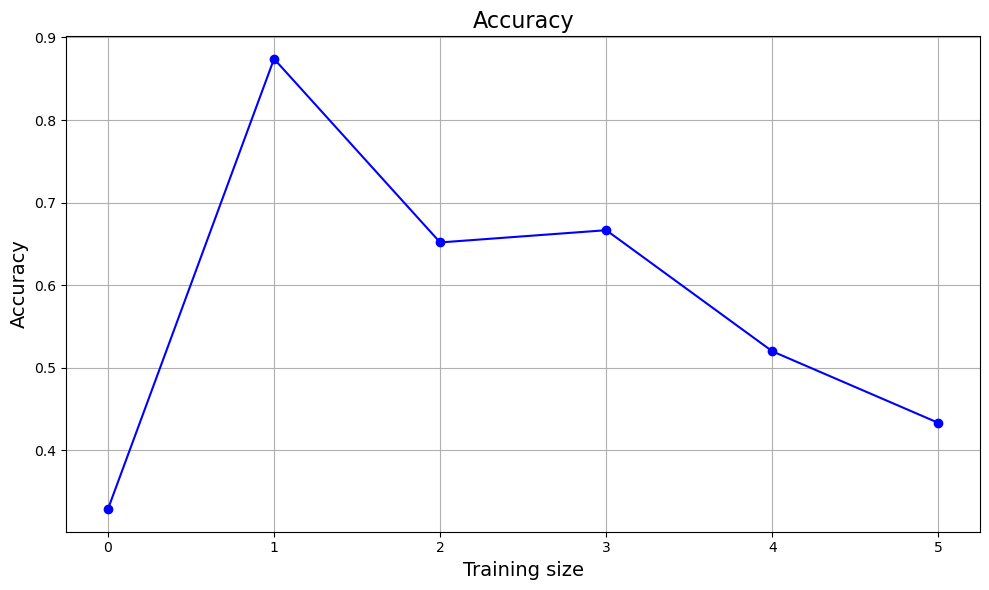

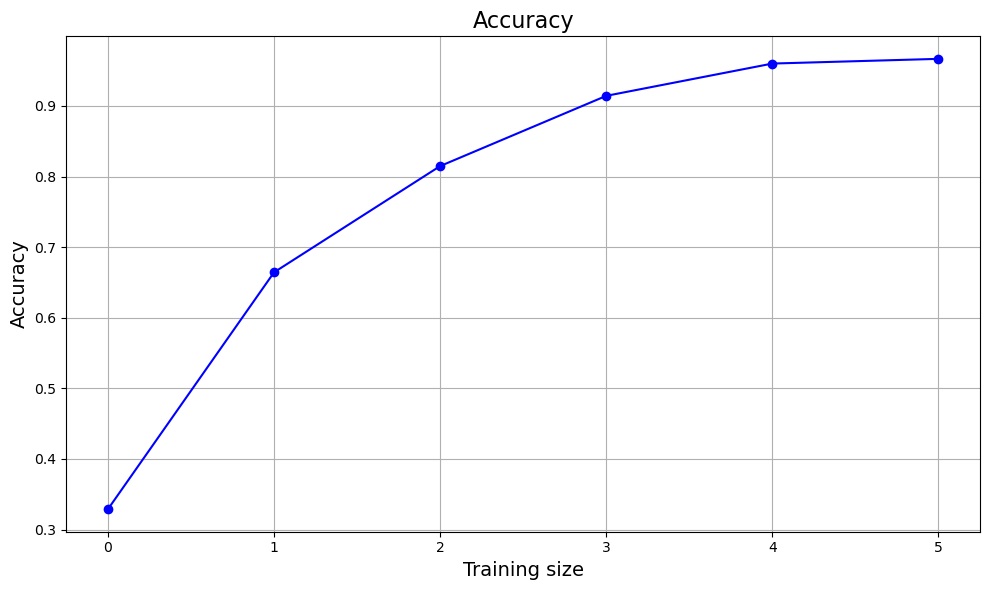

In [370]:
def plot(accuracies, title="Accuracy", x_label="Training size", y_label="Accuracy"):
    # Plot the rewards
    plt.figure(figsize=(10, 6))
    plt.plot(accuracies, color="blue", linestyle="-", marker="o")
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def test(bayes):
    accuracies = []
    for train_size in [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]:
        correct_predictions = 0
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
        nb = bayes()
        nb.build_classifier(x_train, y_train)
        for sample, correct_cls in zip(x_test, y_test):
            correct_predictions += nb.predict(sample) == correct_cls
        accuracies.append(correct_predictions/len(y_test))
    plot(accuracies=accuracies)

test(NaiveBayes)
test(GaussianNaiveBayes)